#Mount drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#從Google Drive下載資料
! cp "/content/gdrive/MyDrive/AOI/train_images.zip" /content/

In [ ]:
#資料解壓縮
! unzip /content/train_images.zip > data_unzip.log

In [ ]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from glob import glob

traincsv_path ="/content/gdrive/MyDrive/AOI/train.csv"
testcsv_path ="/content/gdrive/MyDrive/AOI/test.csv"
#image path
imagePaths = glob('/content/train_images/*')

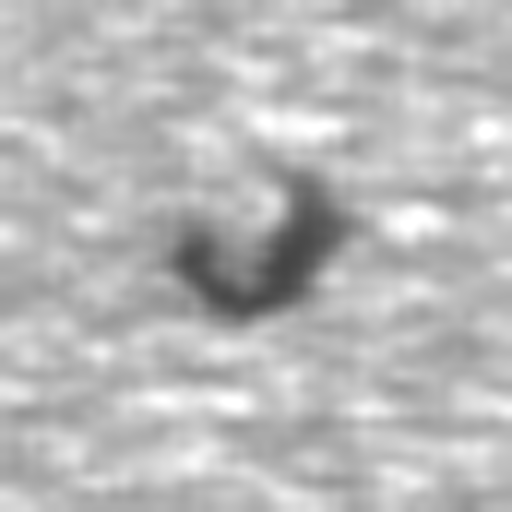

In [ ]:
#查看圖片
#順便看是否以label分類了
from PIL import Image
img = Image.open('/content/train_images/5/train_00009.png')
img

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
img = load_img('/content/train_images/5/train_00003.png')
data = img_to_array(img)
data.shape

(512, 512, 3)

In [ ]:
#讀取csv檔案
traindata_csv = pd.read_csv(traincsv_path)
testdata_csv=pd.read_csv(testcsv_path)
train_data = pd.DataFrame(traindata_csv)
test_data = pd.DataFrame(testdata_csv)#testdata

In [ ]:
train_data.head(10)

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5
5,train_00005.png,5
6,train_00006.png,3
7,train_00007.png,0
8,train_00008.png,3
9,train_00009.png,5


In [ ]:
test_data.head()

,ID,Label
0,test_00000.png,NaN
1,test_00001.png,NaN
2,test_00002.png,NaN
3,test_00003.png,NaN
4,test_00004.png,NaN


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2528 non-null   object
 1   Label   2528 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.6+ KB


#create file & classify

In [ ]:
# create new file
#建立label 0-5 的資料夾
for num in range(6):
  DATASET_PATH = '/content/train_images/'
  class_folders = DATASET_PATH + str(num)

  os.makedirs(class_folders, exist_ok=True)

In [ ]:
# 分別以label去分類圖片

import shutil

for num in range(6):
  labelkind = traindata_csv[traindata_csv["Label"] == num]
  label_list = labelkind["ID"]
  
  for c in label_list:
    shutil.move('/content/train_images/' + str(c), 
                '/content/train_images/' + str(num) + "/" + str(c))

#建立模型

In [ ]:
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator

- Keras的ImageDataGenerator可以方便的读入文件夹中的图片并自动生成训练数据
- data_dir = 'Mushrooms'
train_datagen = ImageDataGenerator(
        rescale=1./255,
        -rescale的作用是对图片的每个像素值均乘上这个放缩因子，设置放缩因子为1/255，把像素值放缩到0和1之间有利于模型的收敛，避免神经元“死亡”。
        shear_range=0.2,
        - 错切变换，效果就是让所有点的x坐标(或者y坐标)保持不变，而对应的y坐标(或者x坐标)则按比例发生平移，且平移的大小和该点到x轴(或y轴)的垂直距离成正比。
        zoom_range=0.2,
        - 可以让图片在长或宽的方向进行放大
        validation_split = 0.3,
        horizontal_flip=True
        -水平翻轉
        -vertical_flip
        -垂直翻轉)
train_generator = train_datagen.flow_from_directory( 生成器的flow_from_directory()方法，从文件中加载图片数据
        data_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='training')

  validation_generator = test_datagen.flow_from_directory(
     - validation_dir,
     - target_size=(150, 150),
     - batch_size=32,
     - class_mode='binary'
)

    


In [ ]:
train_datagen = ImageDataGenerator(rescale= 1. / 255.0, #像素值範圍改為0-1，增加模型收斂
                                   #horizontal_flip=True,
                                   #rotation_range=15, # 角度值，0~180，影象旋轉
                                    validation_split= 0.2)#80%訓練資料，20%驗證資料

In [ ]:
data_dir="/content/train_images/"

In [ ]:
train_generator = train_datagen.flow_from_directory( #加載圖片數據
    data_dir,
    target_size= (224, 224),
    class_mode= "sparse", 
    #batch_size=32,
    subset= "training")

validation_genetator = train_datagen.flow_from_directory(
    data_dir,
    target_size= (224, 224),
    class_mode= "sparse", 
    #batch_size=32,
    subset= "validation")

Found 2025 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
%tensorflow_version 2.x

- from tensorflow.keras.applications.vgg16 import VGG16

- base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
- include_top = False, # Leave out the last fully connected layer
- weights = 'imagenet')

- Since we don’t have to train all the layers, we make them non_trainable:
不用訓練所有layers，所以設置成false

for layer in base_model.layers:
      layer.trainable = False

- https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
在網站上查到的

In [ ]:
#VGG16 try
from keras.applications.vgg16 import VGG16 #load the VGG Model in Keras

base = VGG16(
             input_shape=(224, 224, 3),
             include_top=False
             )

for layer in base.layers:
    layer.trainable = False

** VGG16 model compile & fit 範例 ***

- Flatten the output layer to 1 dimension
- x = layers.Flatten()(base_model.output)

-  Add a fully connected layer with 512 hidden units and ReLU activation
- x = layers.Dense(512, activation='relu')(x)

-  Add a dropout rate of 0.5
- x = layers.Dropout(0.5)(x)

- Add a final sigmoid layer for classification
- x = layers.Dense(1, activation='sigmoid')(x)

- model = tf.keras.models.Model(base_model.input, x)

- model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [ ]:
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D

x = Flatten()(base.output)
x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
x = Dense(64, activation=LeakyReLU(alpha=0.2))(x)
output = Dense(6, activation="softmax")(x)#0-5 label

from keras.models import Model
model = Model(base.input, output)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

#train model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer= Adam(learning_rate=0.0001),
              loss= SparseCategoricalCrossentropy(),
              metrics= ['acc'])

In [ ]:
from keras.callbacks import EarlyStopping
#vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10) 範例
history = model.fit(train_generator,
                    epochs=50, 
                    verbose=2,
                    validation_data= validation_genetator
         )

Epoch 1/50
64/64 - 14s - loss: 0.7180 - acc: 0.7358 - val_loss: 0.4745 - val_acc: 0.8171
Epoch 2/50
64/64 - 11s - loss: 0.3857 - acc: 0.8523 - val_loss: 0.4781 - val_acc: 0.8072
Epoch 3/50
64/64 - 12s - loss: 0.3300 - acc: 0.8741 - val_loss: 0.3289 - val_acc: 0.8847
Epoch 4/50
64/64 - 11s - loss: 0.2747 - acc: 0.8938 - val_loss: 0.2968 - val_acc: 0.8926
Epoch 5/50
64/64 - 11s - loss: 0.2535 - acc: 0.9062 - val_loss: 0.2599 - val_acc: 0.9185
Epoch 6/50
64/64 - 11s - loss: 0.1899 - acc: 0.9299 - val_loss: 0.2519 - val_acc: 0.9046
Epoch 7/50
64/64 - 11s - loss: 0.1645 - acc: 0.9393 - val_loss: 0.2891 - val_acc: 0.8847
Epoch 8/50
64/64 - 11s - loss: 0.1798 - acc: 0.9348 - val_loss: 0.2927 - val_acc: 0.8887
Epoch 9/50
64/64 - 11s - loss: 0.2006 - acc: 0.9225 - val_loss: 0.2211 - val_acc: 0.9324
Epoch 10/50
64/64 - 11s - loss: 0.1093 - acc: 0.9610 - val_loss: 0.2088 - val_acc: 0.9364
Epoch 11/50
64/64 - 11s - loss: 0.1343 - acc: 0.9541 - val_loss: 0.2483 - val_acc: 0.9404
Epoch 12/50
64/64 -

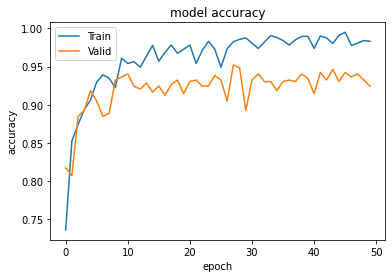

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['Train', 'Valid'], loc='upper left') 
plt.show()

In [ ]:
#從Google Drive 下載test data
! cp "/content/gdrive/MyDrive/AOI/test_images.zip" /content/

In [ ]:
#資料解壓縮
! unzip /content/test_images.zip > data_unzip.log

In [ ]:
# 載入test data
import zipfile

f = zipfile.ZipFile("./gdrive/My Drive/AOI/test_images.zip")
f.extractall("./datasets_test/")

In [ ]:
TestFlowed = train_datagen.flow_from_directory(
    directory = "/content/datasets_test/",
    target_size= (224, 224),
    class_mode= None,
    shuffle= False, 
    )

Found 10142 images belonging to 1 classes.


In [ ]:
predict = model.predict(TestFlowed, verbose=1).argmax(axis=-1)
#預測testdata的label

317/317 [==============================] - 47s 148ms/step


#upload file

In [ ]:
submission =pd.DataFrame({
                             "ID":testdata_csv['ID'],
                             "Label":list(predict)
                        })
submission.to_csv("/content/gdrive/My Drive/AOI_result.csv",index=False)